# 第13章 ニューラルネットワーク

- 著者オリジナル: https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch13/ch13.ipynb
- Theano を使って最適化された機械学習コードを作成する
  - http://deeplearning.net/software/theano/
- 人工ニューラルネットワークの活性化関数を選択する
- すばやく簡単に実験を行うためにディープラーニングライブラリ Keras を使用する
  - https://keras.io/ , https://keras.io/ja/
  
## 13.1 Theano を使った式の構築、コンパイル、実行

### 13.1.1 Theano とは何か

### 13.1.2 はじめてのTheano

```
$ pip install Theano
```

In [16]:
import theano
from theano import tensor as T

# 初期化: scalar メソッドではスカラー(単純な配列)を生成
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# コンパイル
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 実行
net_input(2.0, 1.0, 0.5)

array(2.5)

### 13.1.3 Theano を設定する

In [17]:
# 浮動小数点数の型のデフォルトを確認
print(theano.config.floatX)

# 浮動小数点数の型を float32 に設定
# GPU の場合は float32 にしないといけないらしい
theano.config.floatX = 'float32'

# CPU と GPU どっちを使うかの設定を確認
print(theano.config.device)

float64
cpu


- 環境変数で設定の変更が可能

```
export THEANO_FLAGS=floatX=float32
```

- cpuを使って計算する場合

```
THEANO_FLAGS=device=cpu,floatX=float64 python <pythonスクリプト>
```

- gpuを使う場合

```
THEANO_FLAGS=device=gpu,floatX=float32 python <pythonスクリプト>
```

- ~/.theanorc ファイルにデフォルト設定を書くことも可能

```
[global]
floatX=float32
device-gpu
```

### 13.1.4 配列構造を操作する

In [18]:
import numpy as np

# 初期化
# Theanoを64ビットモードで実行している場合は、fmatrixの代わりにdmatrixを使用する必要がある
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# コンパイル
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# 実行(Pythonリスト)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

# 実行(Numpy配列)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [21]:
import theano
from theano import tensor as T

# 初期化
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# 実行
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z{}:'.format(i), net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [22]:
import theano
from theano import tensor as T

# 初期化
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# 実行
for i in range(5):
    print('z{}:'.format(i), net_input())

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


### 13.1.5 線形回帰の例

In [23]:
import numpy as np
# 10個のトレーニングサンプルが含まれた、1次元のデータセットを作成する
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

In [24]:
import theano
from theano import tensor as T
import numpy as np

def training_linreg(X_train, y_train, eta, epochs):
    costs = []
    # 配列の初期化
    eta0 = T.fscalar('eta0') # float32型のスカラーのインスタンス
    y = T.fvector(name='y') # float32型のベクトルのインスタンス
    X = T.fmatrix(name='X') # float32型の行列のインスタンス
    # 重み w を関数内で参照可能な共有変数として作成
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1), dtype=theano.config.floatX), name='w')
    
    # コストの計算
    net_input = T.dot(X, w[1:]) + w[0] # 重みを用いて総入力を計算
    errors = y - net_input # yと総入力の誤差
    cost = T.sum(T.pow(errors, 2)) # 誤差との2重和
    
    # 重みの更新
    gradient = T.grad(cost, wrt=w) # コストの勾配
    update = [(w, w - eta0 * gradient)] # コストの勾配に学習率をかけて、重み w を更新
    
    # モデルのコンパイル
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X: X_train, y: y_train})
    
    for _ in range(epochs):
        costs.append(train(eta))
        
    return costs, w

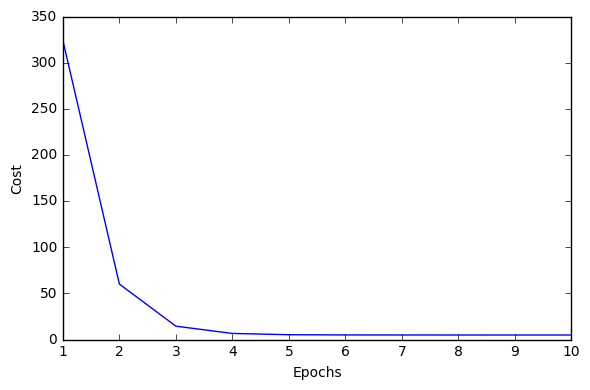

In [25]:
import matplotlib.pyplot as plt
costs, w = training_linreg(X_train, y_train, eta=0.001, epochs=10)

plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

In [26]:
# 入力特徴量に基づいて予測する
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    
    return predict(X)


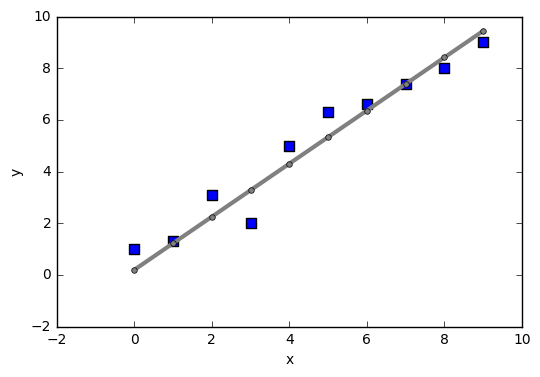

In [27]:
import matplotlib.pyplot as plt
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w), color='gray', marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 13.2 フィードフォワードニューラルネットワークでの活性化関数の選択

### 13.2.1 ロジスティック関数のまとめ

In [8]:
import numpy as np

X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)
print('P(y=1|x) = {:.3f}'.format(logistic_activation(X, w)[0]))

0.706822221094
P(y=1|x) = 0.707


In [9]:
# W : array, shape = [n_output_units, n_hidden_units+1]
# 隠れ層 -> 出力層の重み行列
# 最初の列 (W[:][0]) がバイアスユニットであることに注意
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
# 各礼装の活性化
# 最初の要素 (A[0][0] = 1) がバイアスユニットであることに注意

A = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# Z : array, shape = [n_output_units, n_samples]
# 出力層の総入力

Z = W.dot(A) 
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [10]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


### 13.2.2 ソフトマックス関数を使って多クラス分類の確率を推定する

In [28]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def sotmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print(y_probas)
print(y_probas.sum())

[[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]
1.0


In [31]:
y_class = np.argmax(Z, axis=0)
y_class[0]

2

### 双曲線正接関数を使って出力範囲を拡大する

* 双曲線正接関数(hyperbolic tangent: tanh)

# 13.3 Kerasを使ったニューラルネットワークの効率的なトレーニング

```
pip install Keras
```

- MNIST データセット http://yann.lecun.com/exdb/mnist/
  - train-images-idx3-ubyte.gz: training set images (9,912,422 bytes)
  - train-labels-idx1-ubyte.gz: training set labels (28,881 bytes)
  - t10k-images-idx3-ubyte.gz: test set images (1,648,877 bytes)
  - t10k-labels-idx1-ubyte.gz: test set labels (4,542 bytes)


In [32]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [34]:
X_train, y_train = load_mnist('mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [35]:
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [36]:
import theano 

theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

* Mac でバックエンドを theano にするために `~/.keras/keras.json` を書き換える
* 参考: [バックエンド - Keras Documentation](https://keras.io/ja/backend/ "バックエンド - Keras Documentation")

In [38]:
from keras.utils import np_utils

print('First 3 labels: ', y_train[:3])

y_train_ohe = np_utils.to_categorical(y_train) 
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

Using Theano backend.


First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [44]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1) 

# モデルを初期化
model = Sequential()

# 1つ目の隠れ層を追加
model.add(Dense(input_dim=X_train.shape[1], # 入力ユニット数
                output_dim=50, # 出力ユニット数
                init='uniform', # 重みを一様乱数で初期化
                activation='tanh')) # 活性化関数(双曲線正接関数)

# 2つ目の隠れ層を追加
model.add(Dense(input_dim=50, 
                output_dim=50, 
                init='uniform', 
                activation='tanh'))

# 出力層を追加
model.add(Dense(input_dim=50, 
                output_dim=y_train_ohe.shape[1], 
                init='uniform', 
                activation='softmax'))

# モデルコンパイル時のオプティマイザを設定
# SGD: 確率的勾配降下法
# 引数に学習率、荷重減衰定数、モーメンタム学習を設定
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
# モデルをコンパイル
model.compile(loss='categorical_crossentropy', # コスト関数
              optimizer=sgd) # オプティマイザ


In [45]:
model.fit(X_train, # トレーニングデータ
          y_train_ohe, # 出力データ
          nb_epoch=50, # エポック数
          batch_size=300, # バッチサイズ
          verbose=1,  # 実行時にメッセージを出力
          validation_split=0.1, # 検証用データの割合
          show_accuracy=True) 

/Users/takanori/Private/python-machine-learning/venv/lib/python3.5/site-packages/keras/models.py:635: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s - loss: 2.2290 - val_loss: 2.1092
Epoch 2/50
54000/54000 [==============================] - 1s - loss: 1.8848 - val_loss: 1.6075
Epoch 3/50
54000/54000 [==============================] - 1s - loss: 1.3915 - val_loss: 1.1670
Epoch 4/50
54000/54000 [==============================] - 1s - loss: 1.0612 - val_loss: 0.9042
Epoch 5/50
54000/54000 [==============================] - 0s - loss: 0.8575 - val_loss: 0.7342
Epoch 6/50
54000/54000 [==============================] - 1s - loss: 0.7237 - val_loss: 0.6145
Epoch 7/50
54000/54000 [==============================] - 1s - loss: 0.6247 - val_loss: 0.5443
Epoch 8/50
54000/54000 [==============================] - 1s - loss: 0.5552 - val_loss: 0.4762
Epoch 9/50
54000/54000 [==============================] - 1s - loss: 0.5000 - val_loss: 0.4247
Epoch 10/50
54000/54000 [==============================] - 1s - loss: 0.4582 - val_loss: 0.3914


In [46]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [47]:
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 93.81%


In [48]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 93.71%
